# 텍스트 벡터화하기

예상했겠지만 텍스트 벡터화의 목표는 텍스트 입력을 수치 표현으로 변환하는 것입니다. 이상적으로는 이 수치 표현이 머신러닝 모델이 텍스트에 있는 패턴을 쉽게 감지할 수 있도록 의미있는 정보를 나타내야합니다.

텍스트를 벡터화하는 방법에는 여러 가지가 있습니다. 여기서는 두 가지를 소개합니다:
- TF-IDF는 주어진 말뭉치에서 단어의 상대적인 등장 횟수를 기반으로 문서를 벡터화합니다.
- 사전 훈련된 모델로 다른 말뭉치의 정보를 활용합니다.

데이터 분할 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/splitting_data.ipynb)에서처럼 데이터를 로드하고 훈련 세트와 테스트 세트로 분할합니다.

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import format_raw_df, get_split_by_author
from ml_editor.data_visualization import plot_embeddings

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

## TF-IDF

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)는 전체 말뭉치와 비교하여 문서에 있는 각 단어의 상대적인 빈도를 기반으로 임베딩을 만듭니다. `sklearn`을 사용해 TF-IDF를 만듭니다.

In [2]:
questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]
# 그래프에 컬러로 표시할 레이블을 추출합니다.
# 이 레이블은 분류기를 위한 레이블과 같을 필요는 없습니다.
sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

True     2907
False    2769
Name: AcceptedAnswerId, dtype: int64

In [3]:
# tfidf 객체를 만듭니다.
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# 데이터셋에 있는 질문에 적용합니다.
# 벡터화된 배열을 반환합니다.
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5676, 27381)

이제 텍스트를 벡터화했습니다. 이 과정을 임베딩이라 부르지만 결과 벡터를 임베딩이라고도 합니다. 임베딩 벡터를 PCA, t-SNE, [UMAP](https://umap-learn.readthedocs.io/en/latest/) 등과 같은 차원 축소 기법을 사용해 2차원에 투영하여 시각화할 수 있습니다. 여기서는 UMAP을 사용합니다.

In [4]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

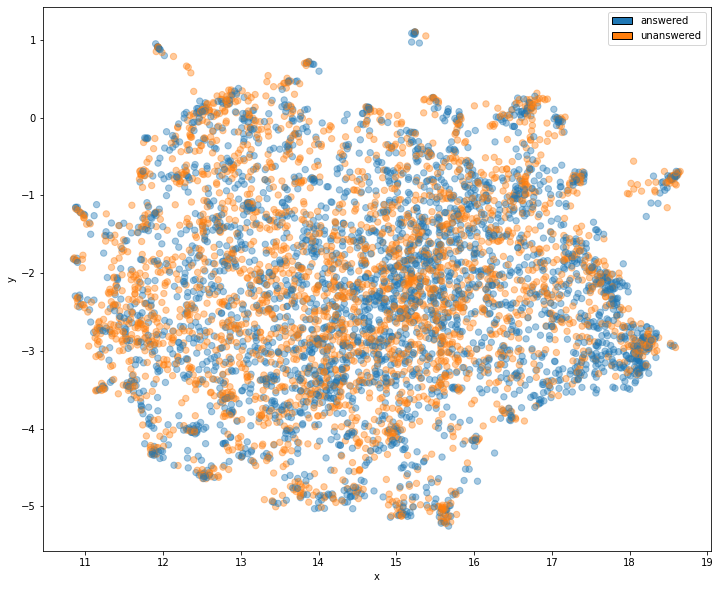

In [5]:
plot_embeddings(umap_bow, sent_labels)

데이터를 간결하게 표혔했지만 트렌드를 보거나 향후 레이블링을 하는데 도움이 됩니다(실제 벡터는 2차원보다 훨씬 큽니다). 특성을 추가할 때 클래스 분할이 잘 되는지 확인하기 위해 임베딩을 시각화할 가치가 있습니다.

## 사전 훈련딘 단어 임베딩

두 번째 방법은 매우 큰 말뭉치에서 훈련된 기존 단어 벡터를 로드하여 현재 말뭉치를 넘어서 일반적인 정보를 활용하는 것입니다. `spacy` 라이브러리를 사용해 이를 수행해 보죠.

먼저 터미널에서 다음 명령으로 `en_core_web_lg`를 다운로드합니다.

`python -m spacy download en_core_web_lg`

In [6]:
# 라지 모델을 로드하고 이 작업에 불필요한 요소를 제외합니다.
# 이렇게 하면 벡터화 과정의 속도를 크게 높일 수 있습니다.
# 모델에 대한 자세한 내용은 https://spacy.io/models/en#en_core_web_lg 을 참고하세요.
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])

In [7]:
# 각 질문에 대한 벡터를 얻습니다.
# 기본적으로 반환된 벡터는 문장에 있는 모든 벡터의 평균입니다.
# 자세한 내용은 https://spacy.io/usage/vectors-similarity 을 참고하세요.
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [8]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

UMAP을 사용해 사전 훈련된 임베딩을 시각화해 보죠.

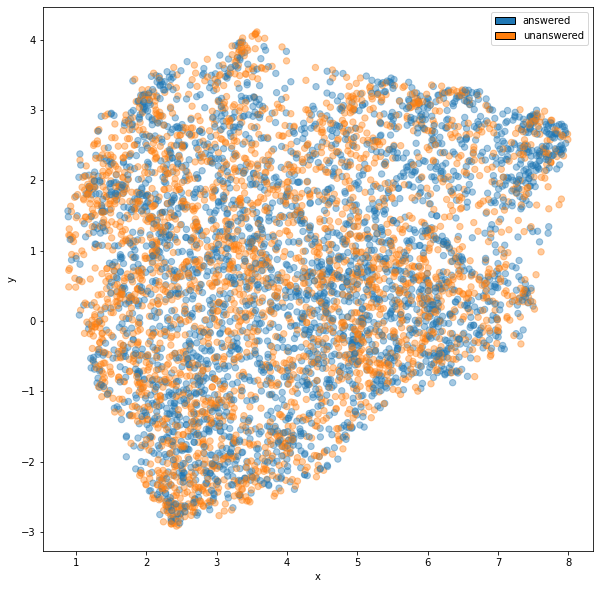

In [9]:
plot_embeddings(umap_emb, sent_labels)

import matplotlib.pyplot as plt
plt.savefig('../images/bmlpa_figures/ch04-9.png', dpi=300)

임베딩 방법이 다르기 때문에 이 데이터셋의 위상이 다릅니다. 하지만 내재된 데이터는 동일합니다.

임베딩 방법이 다르면 데이터셋을 다르게 표현하게 됩니다. 현재 데이터에서 훈련된 임베딩을 사용할 때 동일한 어휘를 사용한 문서가 가깝게 임베딩될 것입니다. 하지만 다른 말뭉치에서 훈련된 모델을 사용하면 이 말뭉치의 정보를 활용할 수 있습니다. 이런 모델을 사용하면 완전히 다른 어휘를 사용하도라도 의미적으로 비슷한 문장이 서로 가깝게 임베딩될 수 있습니다.

데이터 벡터화 방식을 바꾸면 모델 성능에 큰 영향을 끼치는 경우가 종종 있습니다.